# Entanglement renormalization

One can open this notebook in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/master/docs/source/entanglement_renormalization.ipynb)

In the given tutorial, we show how the Riemannian optimization on the complex Stiefel manifold can be used to perform entanglement renormalization and find the ground state energy and the ground state itself of a many-body spin system at the point of quantum phase transition. First of all, let us import the necessary libraries.

In [ ]:
import numpy as np
from scipy import integrate
import tensorflow as tf  # tf 2.x

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

# TensorNetwork library
try:
    import tensornetwork as tn
except ImportError:
    !pip install tensornetwork
    import tensornetwork as tn

import matplotlib.pyplot as plt
from tqdm import tqdm
tn.set_default_backend("tensorflow")

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## 1. Renormalization layer

First of all, one needs to define a renormalization (mera) layer. We use ncon API from TensorNetwork library for these purposes. The function mera_layer takes unitary and isometric tensors (building blocks) and performs renormalization of a local Hamiltonian as it is shown on the tensor diagram below (if the diagram is not displayed here, please open the notebook in Google Colab).
![renorm_layer.png](https://github.com/LuchnikovI/QGOpt/blob/master/docs/source/images/renorm_layer.png?raw=1)
For more information about entanglement renormalization please see

Evenbly, G., & Vidal, G. (2009). Algorithms for entanglement renormalization. Physical Review B, 79(14), 144108.

Evenbly, G., & Vidal, G. (2014). Algorithms for entanglement renormalization: boundaries, impurities and interfaces. Journal of Statistical Physics, 157(4-5), 931-978.

For more information about ncon notation see for example

Pfeifer, R. N., Evenbly, G., Singh, S., & Vidal, G. (2014). NCON: A tensor network contractor for MATLAB. arXiv preprint arXiv:1402.0939.

In [2]:
@tf.function
def mera_layer(H,
               U,
               U_conj,
               Z_left,
               Z_right,
               Z_left_conj,
               Z_right_conj):
    """
    Renormalizes local Hamiltonian.

    Args:
        H: complex valued tensor of shape (chi, chi, chi, chi),
            input two-side Hamiltonian (a local term).
        U: complex valued tensor of shape (chi ** 2, chi ** 2), disentangler
        U_conj: complex valued tensor of shape (chi ** 2, chi ** 2),
            conjugated disentangler.
        Z_left: complex valued tensor of shape (chi ** 3, new_chi),
            left isometry.
        Z_right: complex valued tensor of shape (chi ** 3, new_chi),
            right isometry.
        Z_left_conj: complex valued tensor of shape (chi ** 3, new_chi),
            left conjugated isometry.
        Z_right_conj: complex valued tensor of shape (chi ** 3, new_chi),
            right conjugated isometry.

    Returns: 
        complex valued tensor of shape (new_chi, new_chi, new_chi, new_chi),
        renormalized two side hamiltonian.
        
    Notes:
        chi is the dimension of an index. chi increases with the depth of mera, however,
        at some point, chi is cut to prevent exponential growth of indices
        dimensionality."""

    # index dimension before renormalization
    chi = tf.cast(tf.math.sqrt(tf.cast(tf.shape(U)[0], dtype=tf.float64)),
                  dtype=tf.int32)

    # index dimension after renormalization
    chi_new = tf.shape(Z_left)[-1]

    # List of building blocks
    list_of_tensors = [tf.reshape(Z_left, (chi, chi, chi, chi_new)),
                       tf.reshape(Z_right, (chi, chi, chi, chi_new)),
                       tf.reshape(Z_left_conj, (chi, chi, chi, chi_new)),
                       tf.reshape(Z_right_conj, (chi, chi, chi, chi_new)),
                       tf.reshape(U, (chi, chi, chi, chi)),
                       tf.reshape(U_conj, (chi, chi, chi, chi)),
                       H]

    # structures (ncon notation) of three terms of ascending super operator
    net_struc_1 = [[1, 2, 3, -3], [9, 11, 12, -4], [1, 6, 7, -1],
                   [10, 11, 12, -2], [3, 9, 4, 8], [7, 10, 5, 8], [6, 5, 2, 4]]
    net_struc_2 = [[1, 2, 3, -3], [9, 11, 12, -4], [1, 2, 6, -1],
                   [10, 11, 12, -2], [3, 9, 4, 7], [6, 10, 5, 8], [5, 8, 4, 7]]
    net_struc_3 = [[1, 2, 3, -3], [9, 10, 12, -4], [1, 2, 5, -1],
                   [8, 11, 12, -2], [3, 9, 4, 6], [5, 8, 4, 7], [7, 11, 6, 10]]

    # sub-optimal contraction orders for three terms of ascending super operator
    con_ord_1 = [4, 5, 8, 6, 7, 1, 2, 3, 11, 12, 9, 10]
    con_ord_2 = [4, 7, 5, 8, 1, 2, 11, 12, 3, 6, 9, 10]
    con_ord_3 = [6, 7, 4, 11, 8, 12, 10, 9, 1, 2, 3, 5]

    # ncon
    term_1 = tn.ncon(list_of_tensors, net_struc_1, con_ord_1)
    term_2 = tn.ncon(list_of_tensors, net_struc_2, con_ord_2)
    term_3 = tn.ncon(list_of_tensors, net_struc_3, con_ord_3)

    return (term_1 + term_2 + term_3) / 3  # renormalized hamiltonian

# auxiliary functions that return initial isometries and disentanglers
@tf.function
def z_gen(chi, new_chi):
    """Returns random isometry.

    Args:
        chi: int number, input chi.
        new_chi: int number, output chi.

    Returns:
        complex valued tensor of shape (chi ** 3, new_chi)."""
    
    # one can use the complex Stiefel manfiold to generate a random isometry
    m = qgo.manifolds.StiefelManifold()
    return m.random((chi ** 3, new_chi), dtype=tf.complex128)


@tf.function
def u_gen(chi):
    """Returns the identity matrix of a given size (initial disentangler).

    Args:
        chi: int number.

    Returns:
        complex valued tensor of shape (chi ** 2, chi ** 2)."""
    
    return tf.eye(chi ** 2, dtype=tf.complex128)

## 2. Transverse-field Ising (TFI) model hamiltonian and MERA building blocks

Here we define the Transverse-field Ising model Hamiltonian and building blocks (disentanglers and isometries) of MERA network that will be optimized.

First of all we initialize hyper parameters of MERA and TFI hamiltonian.

In [3]:
max_chi = 4 # max bond dim
num_of_layers = 5 # number of MERA layers (corresponds to 2*3^5 = 486 spins)
h_x = 1 # value of transverse field in TFI model (h_x=1 is the critical field)

One needs to define Pauli matrices. Here all Pauli matrices are represented as one tensor of size $3\times 2 \times 2$, where the first index enumerates a particular Pauli matrix, and the remaining two indices are matrix indices.

In [4]:
sigma = tf.constant([[[1j*0, 1 + 1j*0], [1 + 1j*0, 0*1j]],
                    [[0*1j, -1j], [1j, 0*1j]],
                    [[1 + 0*1j, 0*1j], [0*1j, -1 + 0*1j]]], dtype=tf.complex128)

Here we define local term of the TFI hamiltonian.

In [5]:
zz_term = tf.einsum('ij,kl->ikjl', sigma[2], sigma[2])
x_term = tf.einsum('ij,kl->ikjl', sigma[0], tf.eye(2, dtype=tf.complex128))
h = -zz_term - h_x * x_term

Here we define initial disentanglers, isometries, and state in the renormalized space.

In [6]:
# disentangler U and isometry Z in the first MERA layer
U = u_gen(2)
Z = z_gen(2, max_chi)

# lists with disentanglers and isometries in the rest of the layers
U_list = [u_gen(max_chi) for _ in range(num_of_layers - 1)]
Z_list = [z_gen(max_chi, max_chi) for _ in range(num_of_layers - 1)]

# lists with all disentanglers and isometries
U_list = [U] + U_list
Z_list = [Z] + Z_list

# initial state in the renormalized space (low dimensional in comparison
# with the dimensionality of the initial problem)
psi = tf.ones((max_chi ** 2, 1), dtype=tf.complex128)
psi = psi / tf.linalg.norm(psi)

# converting disentanglers, isometries, and initial state to real
# representation (necessary for the further optimizer)
U_list = list(map(qgo.manifolds.complex_to_real, U_list))
Z_list = list(map(qgo.manifolds.complex_to_real, Z_list))
psi = qgo.manifolds.complex_to_real(psi)

# wrapping disentanglers, isometries, and initial state into
# tf.Variable (necessary for the further optimizer)
U_var = list(map(tf.Variable, U_list))
Z_var = list(map(tf.Variable, Z_list))
psi_var = tf.Variable(psi)

## 3. Optimization of MERA

MERA parametrizes quantum state $\Psi(U, Z, \psi)$ of a spin system, where $U$ is a set of disentanglers, $Z$ is a set of isometries, and $\psi$ is a state in the renormalized space.
In order to find the ground state and its energy, we perform optimization of variational energy $$\langle\Psi(U, Z, \psi)|H_{\rm TFI}|\Psi(U, Z, \psi)\rangle\rightarrow \min_{U, \ Z, \ \psi \in {\rm Stiefel \ manifold}}$$

First of all, we define the parameters of optimization. In order to achieve better convergence, we decrease the learning rate with the number of iteration according to the exponential law.

In [7]:
iters = 3000 # number of iterations
lr_i = 0.6 # initial learning rate
lr_f = 0.05 # final learning rate

# learning rate is multiplied by this coefficient each iteration
decay = (lr_f / lr_i) ** (1 / iters)

Here we define an example of the complex Stiefel manifold necessary for Riemannian optimization and Riemannian Adam optimizer.

In [8]:
m = qgo.manifolds.StiefelManifold()  # complex Stiefel manifold
opt = qgo.optimizers.RAdam(m, lr_i)  # Riemannian Adam

Finally, we perform an optimization loop.

In [9]:
# this list will be filled by the value of variational energy per iteration
E_list = []

# optimization loop
for j in tqdm(range(iters)):

    # gradient calculation
    with tf.GradientTape() as tape:

        # convert real valued variables back to complex valued tensors
        U_var_c = list(map(qgo.manifolds.real_to_complex, U_var))
        Z_var_c = list(map(qgo.manifolds.real_to_complex, Z_var))
        psi_var_c = qgo.manifolds.real_to_complex(psi_var)

        # initial local Hamiltonian term
        h_renorm = h
        
        # renormalization of a local Hamiltonian term
        for i in range(len(U_var)):
            h_renorm = mera_layer(h_renorm,
                                  U_var_c[i],
                                  tf.math.conj(U_var_c[i]),
                                  Z_var_c[i],
                                  Z_var_c[i],
                                  tf.math.conj(Z_var_c[i]),
                                  tf.math.conj(Z_var_c[i]))
            
        # renormalizad Hamiltonian (low dimensional)
        h_renorm = (h_renorm + tf.transpose(h_renorm, (1, 0, 3, 2))) / 2
        h_renorm = tf.reshape(h_renorm, (max_chi * max_chi, max_chi * max_chi))
        
        # energy
        E = tf.cast((tf.linalg.adjoint(psi_var_c) @ h_renorm @ psi_var_c),
                    dtype=tf.float64)[0, 0]
        
    # adding current variational energy to the list
    E_list.append(E)

    # gradients
    grad = tape.gradient(E, U_var + Z_var + [psi_var])
    
    # optimization step
    opt.apply_gradients(zip(grad, U_var + Z_var + [psi_var]))
    
    # learning rate update
    opt._set_hyper("learning_rate", opt._get_hyper("learning_rate") * decay)

100%|██████████| 3000/3000 [06:21<00:00,  7.87it/s]


Here we compare exact ground state energy with MERA based value. We also plot how the difference between exact ground state energy and MERA-based energy evolves with the number of iteration.

MERA energy: -1.2731094185716914
Exact energy: -1.2732417615356748


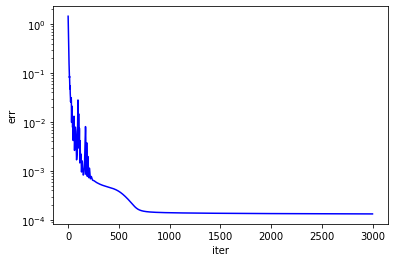

In [10]:
# exact value of ground state energy in the critical point
N = 2 * (3 ** num_of_layers) # number of spins (for 5 layers one has 486 spins)
E0_exact_fin = -2 * (1 / np.sin(np.pi / (2 * N))) / N # exact energy per spin

plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')
plt.plot(E_list - tf.convert_to_tensor(([E0_exact_fin] * len(E_list))), 'b')
print("MERA energy:", E_list[-1].numpy())
print("Exact energy:", E0_exact_fin)